<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Computer%20Vision/e_waste_image_dataset_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.0 MB/s eta 0:00:00


In [ ]:
! pip install -U transformers

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00


Importing necessary libraries and modules

In [ ]:
 # Import the 'warnings' module for handling warnings
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization

from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score
)

# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler
import evaluate
from datasets import Dataset, Image, ClassLabel

# Import various modules from the Transformers library
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator
)

# Import PyTorch for deep learning
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)

In [ ]:
import accelerate

accelerate.__version__

'0.24.1'

In [ ]:
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Import necessary libraries
image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm
import os

file_names = []
labels = []


for file in tqdm(sorted((Path('/content/modified-dataset').glob('*/*/*.*')))):
    label = str(file).split('/')[-2]
    labels.append(label)
    file_names.append(str(file))


print(len(file_names), len(labels))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

100%|██████████| 3000/3000 [00:00<00:00, 348431.65it/s]

3000 3000
(3000, 2)


In [ ]:
df.head()

,image,label
0,/content/modified-dataset/test/Battery/battery...,Battery
1,/content/modified-dataset/test/Battery/battery...,Battery
2,/content/modified-dataset/test/Battery/battery...,Battery
3,/content/modified-dataset/test/Battery/battery...,Battery
4,/content/modified-dataset/test/Battery/battery...,Battery


In [ ]:
df['label'].unique()

array(['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB',
       'Player', 'Printer', 'Television', 'Washing Machine'], dtype=object)

In [ ]:

# 'y' contains the target variable (label) we want to predict
y = df[['label']]

# Drop the 'label' column
df = df.drop(['label'], axis=1)

# Create a RandomOverSampler object
ros = RandomOverSampler(random_state=83)

# Use the RandomOverSampler to resample the dataset
df, y_resampled = ros.fit_resample(df, y)

# Delete the original 'y'
del y

#
df['label'] = y_resampled

# Delete the 'y_resampled'
del y_resampled

# Perform garbage collection
gc.collect()

print(df.shape)

(3000, 2)


Create a dataset from a Pandas DataFrame.

In [ ]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())

Display the first image in the dataset

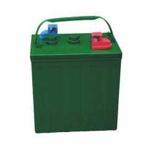

In [ ]:
dataset[0]["image"]

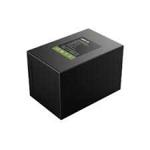

In [ ]:
dataset[1]["image"]

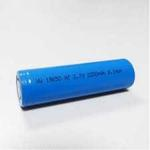

In [ ]:
dataset[2]["image"]

Extracting a subset of elements from the 'labels' list using slicing.

In [ ]:
labels_subset = labels[:5]


print(labels_subset)

['Battery', 'Battery', 'Battery', 'Battery', 'Battery']


 Create a list of unique labels

In [ ]:

labels_list = list(set(labels))


label2id, id2label = dict(), dict()


for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Washing Machine', 1: 'Keyboard', 2: 'Printer', 3: 'PCB', 4: 'Player', 5: 'Microwave', 6: 'Television', 7: 'Mouse', 8: 'Mobile', 9: 'Battery'} 

Mapping of Labels to IDs: {'Washing Machine': 0, 'Keyboard': 1, 'Printer': 2, 'PCB': 3, 'Player': 4, 'Microwave': 5, 'Television': 6, 'Mouse': 7, 'Mobile': 8, 'Battery': 9}


Creating classlabels to match labels to IDs

In [ ]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)


def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)


dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using an 80-20 split ratio.
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = dataset['train']

# Extracting the testing data from the split dataset.
test_data = dataset['test']

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3000 [00:00<?, ? examples/s]

Define the pre-trained ViT model string

In [ ]:
model_str = 'google/vit-base-patch16-224-in21k'


processor = ViTImageProcessor.from_pretrained(model_str)


image_mean, image_std = processor.image_mean, processor.image_std


size = processor.size["height"]
print("Size: ", size)


normalize = Normalize(mean=image_mean, std=image_std)


_train_transforms = Compose(
    [
        Resize((size, size)),
        RandomRotation(10),
        RandomAdjustSharpness(2),
        ToTensor(),
        normalize
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),
        ToTensor(),
        normalize
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Size:  224


Set the transforms for the training data

In [ ]:
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)

Define a collate function that prepares batched data for model training

In [ ]:
def collate_fn(examples):

    pixel_values = torch.stack([example["pixel_values"] for example in examples])


    labels = torch.tensor([example['label'] for example in examples])


    return {"pixel_values": pixel_values, "labels": labels}


Load, train, and evaluate model

In [ ]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))


model.config.id2label = id2label
model.config.label2id = label2id


print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.806346


Load the accuracy metric from a module named 'evaluate'

In [ ]:

accuracy = evaluate.load("accuracy")



def compute_metrics(eval_pred):

    predictions = eval_pred.predictions


    label_ids = eval_pred.label_ids

    # Calculate accuracy using the loaded accuracy metric

    predicted_labels = predictions.argmax(axis=1)

    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']


    return {
        "accuracy": acc_score
    }

In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.35.2', '0.24.1')

In [ ]:
from transformers import TrainingArguments

Define the name of the evaluation metric to be used during training and evaluation.

In [ ]:

metric_name = "accuracy"

# Define the name of the model
model_name = "10_ship_types_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 10

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(

    output_dir=model_name,


    logging_dir='./logs',


    evaluation_strategy="epoch",


    learning_rate=5e-6,


    per_device_train_batch_size=64,


    per_device_eval_batch_size=32,


    num_train_epochs=num_train_epochs,


    weight_decay=0.02,


    warmup_steps=50,


    remove_unused_columns=False,


    save_strategy='epoch',


    load_best_model_at_end=True,


    save_total_limit=1,


    report_to="mlflow"  # log to mlflow
)

Create a Trainer instance for fine-tuning a language model.


In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

Evaluate the pre-training model's performance on a test dataset.

In [ ]:
trainer.evaluate()

{'eval_loss': 2.2783703804016113,
 'eval_accuracy': 0.18,
 'eval_runtime': 14.0132,
 'eval_samples_per_second': 42.817,
 'eval_steps_per_second': 1.356}

 Start training the model using the trainer object

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.248353,0.295000
2,No log,2.167026,0.590000
3,No log,2.077769,0.743333
4,No log,1.987664,0.811667
5,No log,1.908794,0.863333
6,No log,1.841409,0.893333
7,No log,1.788564,0.911667
8,No log,1.750305,0.916667
9,No log,1.726609,0.918333
10,No log,1.718838,0.918333


TrainOutput(global_step=380, training_loss=1.8794700221011513, metrics={'train_runtime': 1066.0111, 'train_samples_per_second': 22.514, 'train_steps_per_second': 0.356, 'total_flos': 1.859941101699072e+18, 'train_loss': 1.8794700221011513, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 1.7188383340835571,
 'eval_accuracy': 0.9183333333333333,
 'eval_runtime': 9.8033,
 'eval_samples_per_second': 61.204,
 'eval_steps_per_second': 1.938,
 'epoch': 10.0}

In [ ]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 1.7188383340835571, 'test_accuracy': 0.9183333333333333, 'test_runtime': 9.845, 'test_samples_per_second': 60.945, 'test_steps_per_second': 1.93}


Accuracy: 0.9183
F1 Score: 0.9175


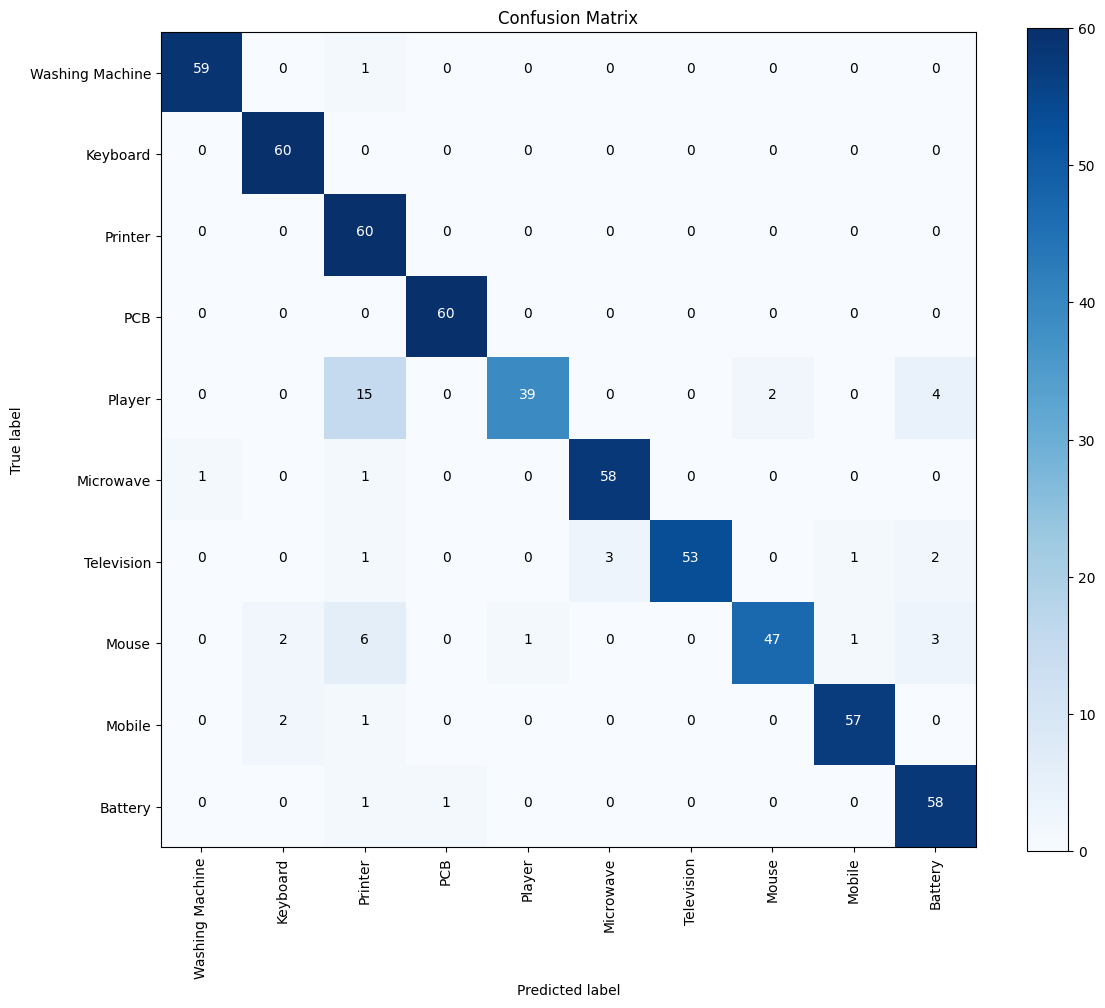


Classification report:

                 precision    recall  f1-score   support

Washing Machine     0.9833    0.9833    0.9833        60
       Keyboard     0.9375    1.0000    0.9677        60
        Printer     0.6977    1.0000    0.8219        60
            PCB     0.9836    1.0000    0.9917        60
         Player     0.9750    0.6500    0.7800        60
      Microwave     0.9508    0.9667    0.9587        60
     Television     1.0000    0.8833    0.9381        60
          Mouse     0.9592    0.7833    0.8624        60
         Mobile     0.9661    0.9500    0.9580        60
        Battery     0.8657    0.9667    0.9134        60

       accuracy                         0.9183       600
      macro avg     0.9319    0.9183    0.9175       600
   weighted avg     0.9319    0.9183    0.9175       600



In [ ]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids


y_pred = outputs.predictions.argmax(1)


def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'

    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()



# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')


print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")


if len(labels_list) <= 250:

    cm = confusion_matrix(y_true, y_pred)


    plot_confusion_matrix(cm, labels_list, figsize=(12, 10))


print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [ ]:
trainer.save_model()

In [ ]:
# Import the 'pipeline' function from the 'transformers' library.
from transformers import pipeline


pipe = pipeline('image-classification', model=model_name, device=0)

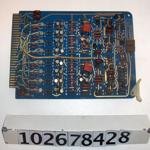

In [ ]:

image = test_data[1]["image"]

# Displaying the 'image' variable.
image

In [ ]:
# Apply the 'pipe' function to process the 'image' variable.
pipe(image)

[{'score': 0.1998816877603531, 'label': 'PCB'},
 {'score': 0.0966096743941307, 'label': 'Washing Machine'},
 {'score': 0.09216290712356567, 'label': 'Television'},
 {'score': 0.09067974984645844, 'label': 'Printer'},
 {'score': 0.09027212858200073, 'label': 'Battery'}]

In [ ]:
# This line of code accesses the "label" attribute of a specific element in the test_data list.

id2label[test_data[1]["label"]]

'PCB'